In [470]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [206]:
data = pd.read_csv('glass.txt', delim_whitespace=True)
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
1,3.01,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,WinF
2,-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,WinF
3,-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,WinF
4,-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,WinF
5,-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,WinF


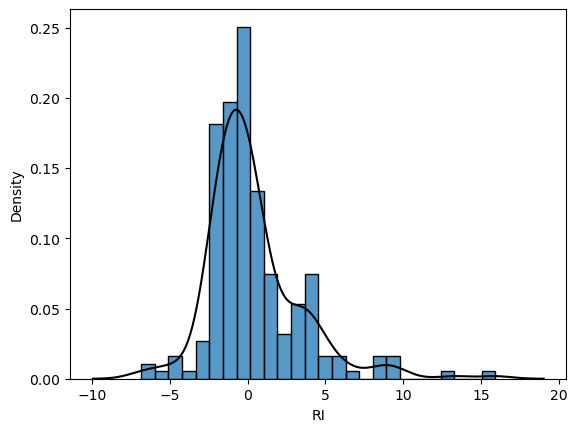

In [207]:
x = sns.histplot(data=data.RI, bins='auto', stat='density')
sns.kdeplot(data=data.RI, color='k', bw_adjust=1)
plt.show()

Histogram:

In [485]:
class histogram:
    def __init__(self, data, num_bins=10, alpha=0.05):
        self.n = len(data)
        self.data = data
        self.alpha = alpha
        self.Xmin = np.min(data)
        self.Xmax = np.max(data)
        self.num_bins = num_bins
        self.bins = np.linspace(self.Xmin, self.Xmax, self.num_bins+1)
        self.h = (self.Xmax-self.Xmin)/num_bins

        x = np.reshape(data, (self.n, 1))
        self.counts = np.sum((x>self.bins[:-1]) & (x<self.bins[1:]), axis=0)
        self.counts[0] += 1
        self.counts[-1] +=1

        self.ps = self.counts / (self.n)

        hcvr = self.h/(self.Xmax - self.Xmin)
        self.cross_validation_risk = (2 / ((self.n - 1) * hcvr)) - np.sum(self.ps ** 2) * (self.n + 1) / (hcvr * (self.n - 1))

    def pdf(self, x):
        return np.take(self.ps, np.floor(self.num_bins * (x-self.Xmin)/(self.Xmax - self.Xmin)).astype(int), mode='clip') / self.h * ((x<self.Xmax) & (x > self.Xmin))
    
    def interval(self, x):
        fx = self.pdf(x)
        a = self.alpha / (2 * self.num_bins)
        c = - np.sqrt(self.num_bins / self.n) * norm.cdf(a) / 2
        return (np.maximum(0, np.sqrt(fx) - c) ** 2, (np.sqrt(fx) + c) ** 2)
        

    def plotpdf(self, interval=False):
        xs = np.linspace(self.Xmin, self.Xmax, 1000)
        ys = self.pdf(xs)
        plt.plot(xs, ys, label = 'pdf')
        if interval:
            lower, upper = self.interval(xs)
            plt.plot(xs, lower, linestyle='--', label = 'upper')
            plt.plot(xs, upper, linestyle='--', label = 'lower')
        return

    

In [486]:
myhist = histogram(data.RI.to_numpy(), num_bins=20)


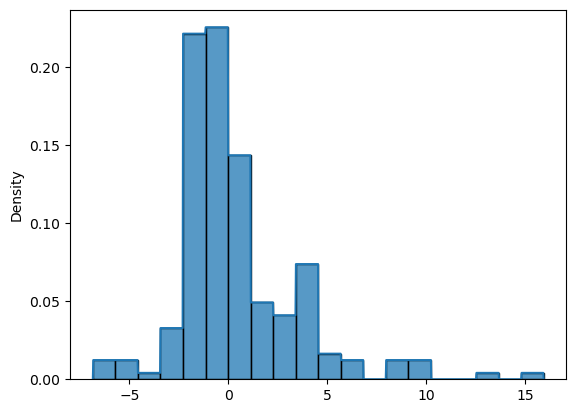

In [487]:
myhist.plotpdf()
sns.histplot(data.RI.to_numpy(), stat='density', bins=20)
plt.show()

In [488]:
ms = np.array(sorted(list(set(np.array(np.logspace(0, 2.5, 100).astype(int))))))
print(ms)
risks = []
for m in ms:
    hist = histogram(data.RI.to_numpy(), num_bins=m)
    risks.append(hist.cross_validation_risk)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  27  29  30  32  34  36  38  41  43  46  49  52
  55  58  62  65  69  73  78  83  87  93  98 104 111 117 124 132 140 148
 157 166 176 187 198 210 223 236 250 265 281 298 316]


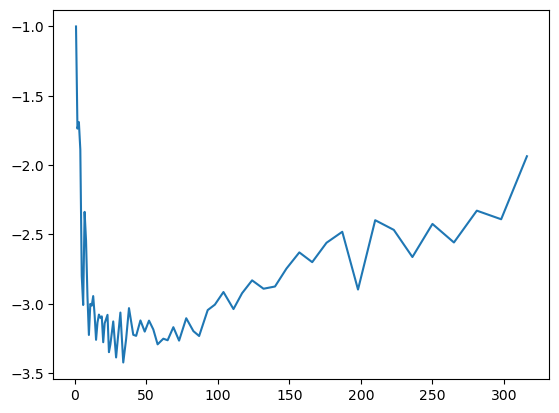

In [489]:
plt.plot(ms, risks)

In [490]:
ms = np.arange(20, 100)
print(ms)
risks = []
for m in ms:
    hist = histogram(data.RI.to_numpy(), num_bins=m)
    risks.append(hist.cross_validation_risk)

[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91
 92 93 94 95 96 97 98 99]


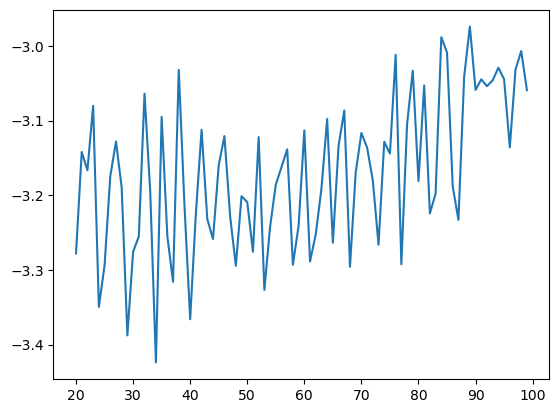

In [491]:
plt.plot(ms, risks)

In [492]:
#best number of bins is

print(ms[np.argmin(risks)])

34


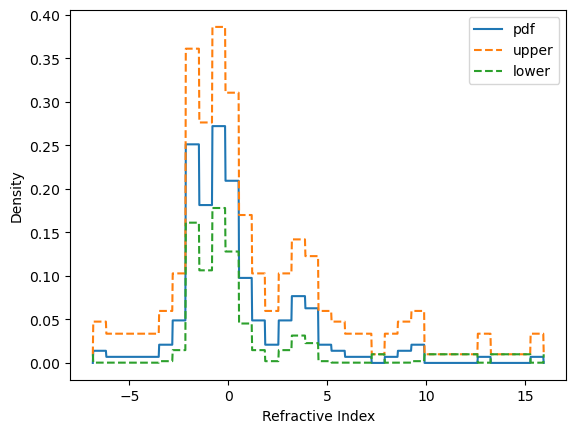

In [493]:
optimalhist = histogram(data=data.RI.to_numpy(), num_bins=34)
optimalhist.plotpdf(interval=True)
plt.legend()
plt.xlabel('Refractive Index')
plt.ylabel('Density')
plt.show()

KDE plot:

In [511]:
norm.pdf([1, 2, 3], loc=[[0], [2]], scale = 0.1)

array([[7.69459863e-022, 5.52094836e-087, 1.47364613e-195],
       [7.69459863e-022, 3.98942280e+000, 7.69459863e-022]])

In [503]:
np.array([[0], [2]]).shape

(2, 1)

In [580]:
class KDE:
    
    def __init__(self, data, bandwidth, K = 'norm', alpha=0.05):
        self.data = data
        self.bandwidth = bandwidth
        self.n = len(self.data)
        self.K = K
        self.Xmin = np.min(self.data)
        self.Xmax = np.max(self.data)
        self.alpha = alpha

    def pdf(self, x):
        if self.K =='norm':
            means = self.data.reshape((self.n, 1))
            pdfs = norm.pdf(x, means, scale = np.sqrt(self.bandwidth))
            return np.sum(pdfs, axis=0)/self.n
    
    def get_cross_validation_risk(self):
        h = self.bandwidth
        n = self.n
        xs = (self.data.reshape(n, 1) - self.data.reshape(1, n)) / h
        return np.sum((norm.pdf(xs, scale=np.sqrt(2)) - 2 * norm.pdf(xs))) / (h * n ** 2) + 2 * norm.pdf(0) / (n * h)

    def intervals(self, x):
        h = self.bandwidth
        omega = 3 * h
        a = self.Xmin - 3 * h
        b = self.Xmax + 3 * h
        m = (b - a)/omega
        q = norm.cdf((1 + (1 - self.alpha) ** (1/m))/2)
        n = self.n
        Yis = norm.pdf(x.reshape(1, len(x)), loc=self.data.reshape(n, 1), scale=np.sqrt(h))
        Ybars = np.mean(Yis, axis=0)
        s2 = np.sum((Yis - Ybars) ** 2, axis=0)
        se = np.sqrt(s2)/n
        f = self.pdf(x)
        return (f - 1 * se, f + q * se)

    def plotpdf(self, interval=False):
        xs = np.linspace(self.Xmin, self.Xmax, 1000)
        ys = self.pdf(xs)
        plt.plot(xs, ys)
        if interval:
            lower, upper = self.intervals(xs)
            plt.plot(xs, lower)
            plt.plot(xs, upper)  
        return      

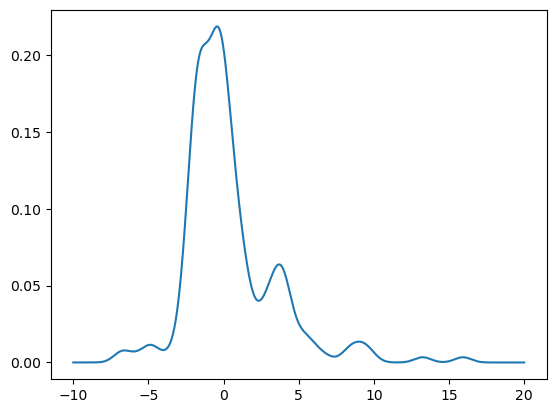

In [581]:
mykde = KDE(data.RI.to_numpy(), 0.3)
xs = np.linspace(-10, 20, 1000)
ys = mykde.pdf(xs)
plt.plot(xs, ys)
plt.show()

In [557]:
bws = np.logspace(-2, 1, 100)
risks = []
for bw in bws:
    testkde = KDE(data = data.RI.to_numpy(), bandwidth=bw)
    risks.append(testkde.get_cross_validation_risk())

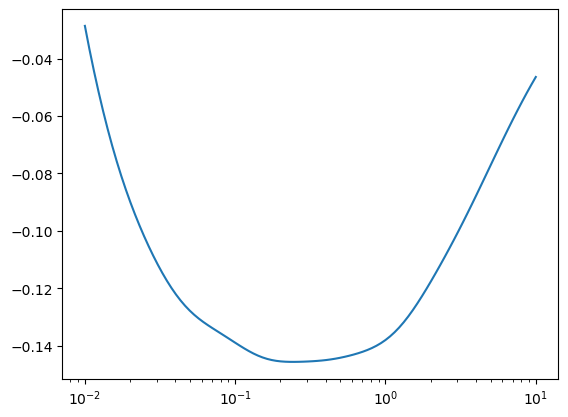

In [558]:
plt.plot(bws, risks)
plt.xscale('log')

In [559]:
bws = np.logspace(-1, 0, 100)
risks = []
for bw in bws:
    testkde = KDE(data = data.RI.to_numpy(), bandwidth=bw)
    risks.append(testkde.get_cross_validation_risk())

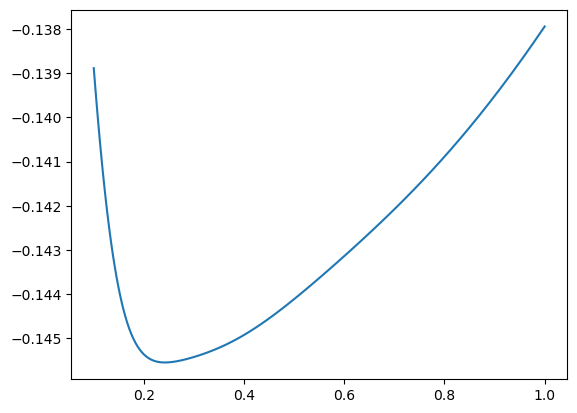

In [560]:
plt.plot(bws, risks)
plt.show()

In [561]:
bws = np.linspace(0.2, 0.3, 100)
risks = []
for bw in bws:
    testkde = KDE(data = data.RI.to_numpy(), bandwidth=bw)
    risks.append(testkde.get_cross_validation_risk())

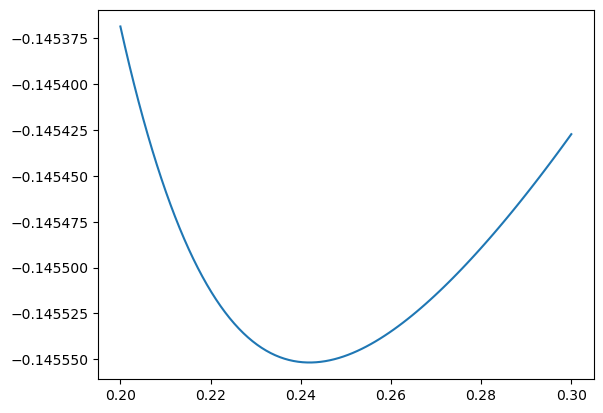

In [562]:
plt.plot(bws, risks)
plt.show()

In [563]:
#best bw is

bwopt = bws[np.argmin(risks)]

print(bwopt)

0.24242424242424243


This is lower than what seaborn uses

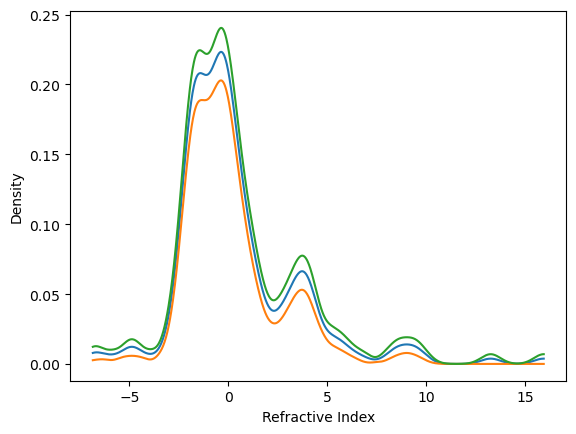

In [572]:
optkde = KDE(data.RI.to_numpy(), bwopt)
optkde.plotpdf(interval=True)
plt.ylabel('Density')
plt.xlabel('Refractive Index')
plt.show()

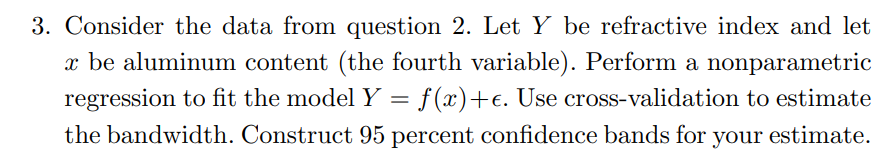

Text(0, 0.5, 'Al content')

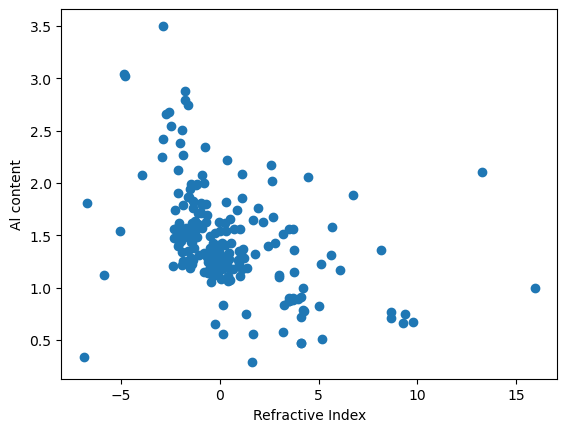

In [579]:
plt.scatter(x=data.RI, y=data.Al)
plt.xlabel('Refractive Index')
plt.ylabel('Al content')

In [657]:
class Nadara_Watson_ke:
    def __init__(self, x, y, bandwidth, K='norm', alpha = 0.05):
        self.x = x
        self.y = y
        self.n = len(data)
        self.bandwidth = bandwidth
        self.Xmax = np.max(x)
        self.Xmin = np.min(x)
        self.alpha = alpha
    
    def regline(self, xs):
        h = self.bandwidth
        xs = xs.reshape(len(xs), 1)
        x = self.x.reshape(1, self.n)
        y = self.y.reshape(1, self.n)
        Zmatrix = norm.pdf((xs - x) / h)
        wi = Zmatrix / np.sum(Zmatrix, axis=1, keepdims=True)
        return np.sum(wi * y, axis=1)
    
    def get_cross_validation_risk(self):
        h = self.bandwidth

        r = self.regline(xs = self.x)

        xi = self.x.reshape(self.n, 1)
        xj = self.x.reshape(1, self.n)

        Zmatrix = norm.pdf((xi - xj) / h)

        terms = (self.y - r) ** 2 / (1 - norm.pdf(0) / np.sum(Zmatrix, axis=1)) ** 2

        return np.sum(terms)

    def intervals(self, xs):
        h = self.bandwidth
        b = self.Xmax + 3 * h
        a = self.Xmin - 3 * h

        y = self.y
        s2 = np.sum((y[1:] - y[:-1]) ** 2) / (2 * (self.n - 1))

        m = (b - a) / h
        q = norm.cdf((1 + (1 - self.alpha) ** (1 / m)) / 2)
        
        xsw = xs.reshape(len(xs), 1)
        xw = self.x.reshape(1, self.n)
        Zmatrix = norm.pdf((xsw - xw) / h)
        wi = Zmatrix / np.sum(Zmatrix, axis=1, keepdims=True)

        se = np.sqrt(s2 * np.sum(wi**2, axis=1))

        r = self.regline(xs)

        return r - q * se, r + q * se

    def regplot(self, interval = False):
        h = self.bandwidth
        xs = np.linspace(self.Xmin - 3 * h, self.Xmax + 3 * h, 10000)
        ys = self.regline(xs)
        
        plt.plot(xs, ys, label='r(x)')
        
        if interval:
            lower, upper = self.intervals(xs)
            plt.plot(xs, lower, label='l(x)')
            plt.plot(xs, upper, label='u(x)')
        return

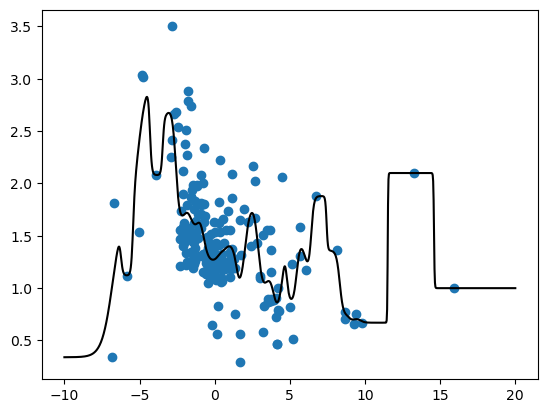

In [645]:
myke = Nadara_Watson_ke(x=data.RI.to_numpy(), y=data.Al.to_numpy(), bandwidth=0.24)
xs = np.linspace(-10, 20, 1000)
ys = myke.regline(xs)
plt.scatter(x=data.RI, y=data.Al)
plt.plot(xs,ys, color='k')
plt.show()

In [646]:
mykde.get_cross_validation_risk()

-0.14542719351395972

C:\Users\HM191112\AppData\Local\Temp\ipykernel_24488\2052233472.py:30: RuntimeWarning: invalid value encountered in divide
  terms = (self.y - r) ** 2 / (1 - norm.pdf(0) / np.sum(Zmatrix, axis=1)) ** 2


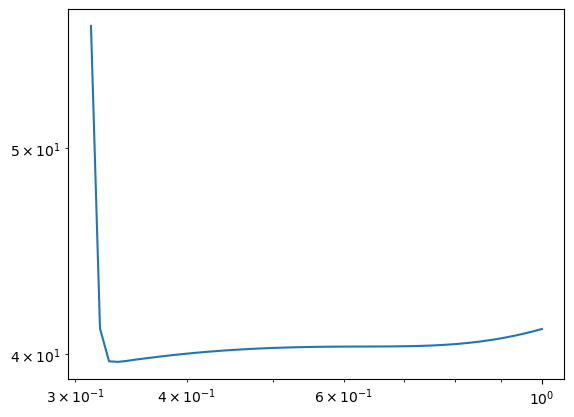

In [647]:
bws = np.logspace(-1, 0, 100)
risks = []
for bw in bws:
    testnwke = Nadara_Watson_ke(x = data.RI.to_numpy(), y=data.Al.to_numpy(), bandwidth=bw)
    risks.append(testnwke.get_cross_validation_risk())
plt.plot(bws, risks)
plt.yscale('log')
plt.xscale('log')
plt.show()

C:\Users\HM191112\AppData\Local\Temp\ipykernel_24488\2052233472.py:30: RuntimeWarning: invalid value encountered in divide
  terms = (self.y - r) ** 2 / (1 - norm.pdf(0) / np.sum(Zmatrix, axis=1)) ** 2
C:\Users\HM191112\AppData\Local\Temp\ipykernel_24488\2052233472.py:30: RuntimeWarning: divide by zero encountered in divide
  terms = (self.y - r) ** 2 / (1 - norm.pdf(0) / np.sum(Zmatrix, axis=1)) ** 2


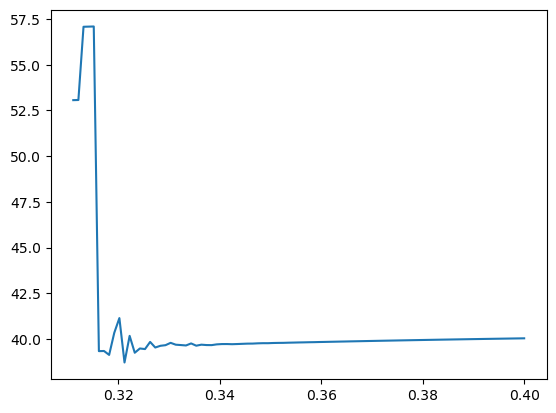

In [649]:
bws = np.linspace(0.3, 0.4, 100)
risks = []
for bw in bws:
    testnwke = Nadara_Watson_ke(x = data.RI.to_numpy(), y=data.Al.to_numpy(), bandwidth=bw)
    risks.append(testnwke.get_cross_validation_risk())
plt.plot(bws, risks)

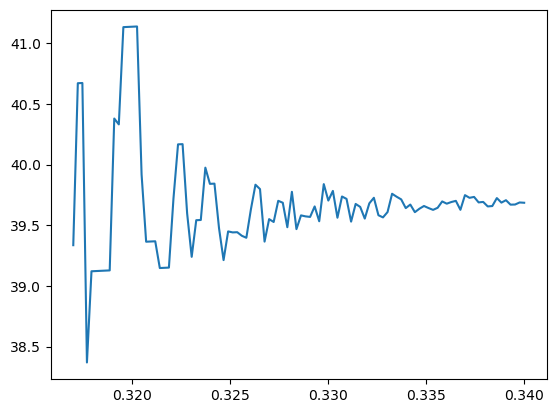

In [619]:
bws = np.linspace(0.317, 0.34, 100)
risks = []
for bw in bws:
    testnwke = Nadara_Watson_ke(x = data.RI.to_numpy(), y=data.Al.to_numpy(), bandwidth=bw)
    risks.append(testnwke.get_cross_validation_risk())
plt.plot(bws, risks)

In [622]:
bestbw = bws[np.argmin(risks)]
print(bestbw)

0.3176969696969697


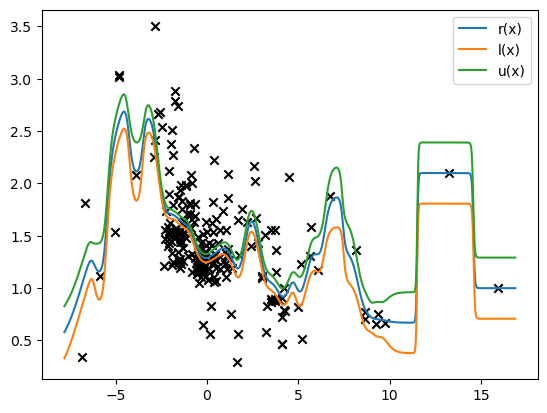

In [660]:
optke = Nadara_Watson_ke(x=data.RI.to_numpy(), y=data.Al.to_numpy(), bandwidth=bestbw)
plt.scatter(x=data.RI, y=data.Al, marker='x', color='k')
optke.regplot(interval=True)
plt.legend()
plt.show()